In [1]:
from __future__ import annotations
import xarray as xr
import numpy as np
import pandas as pd
import xarray as xr
import pv_functions
import os
import glob
import os
import re
import cftime

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


['/groups/EXTREMES/cutouts/europe-1980-era5.nc', '/groups/EXTREMES/cutouts/europe-1981-era5.nc', '/groups/EXTREMES/cutouts/europe-1982-era5.nc', '/groups/EXTREMES/cutouts/europe-1983-era5.nc', '/groups/EXTREMES/cutouts/europe-1984-era5.nc', '/groups/EXTREMES/cutouts/europe-1985-era5.nc', '/groups/EXTREMES/cutouts/europe-1986-era5.nc', '/groups/EXTREMES/cutouts/europe-1987-era5.nc', '/groups/EXTREMES/cutouts/europe-1988-era5.nc', '/groups/EXTREMES/cutouts/europe-1989-era5.nc', '/groups/EXTREMES/cutouts/europe-1990-era5.nc', '/groups/EXTREMES/cutouts/europe-1991-era5.nc', '/groups/EXTREMES/cutouts/europe-1992-era5.nc', '/groups/EXTREMES/cutouts/europe-1993-era5.nc', '/groups/EXTREMES/cutouts/europe-1994-era5.nc', '/groups/EXTREMES/cutouts/europe-1995-era5.nc', '/groups/EXTREMES/cutouts/europe-1996-era5.nc', '/groups/EXTREMES/cutouts/europe-1997-era5.nc', '/groups/EXTREMES/cutouts/europe-1998-era5.nc', '/groups/EXTREMES/cutouts/europe-1999-era5.nc', '/groups/EXTREMES/cutouts/europe-2000-e

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable albedo as the horizontal dimensions for the regridding.
  warnings.warn(


In [59]:
models = ["HadGEM3-GC31-MM"]  # Test with only one model
variants = ["r1i1p1f3"]  # Corresponding variant for the model
period = ["historical"]
base_path="/groups/FutureWind/SFCRAD/"
orientation1='latitude_optimal'
trigon_model='simple'
clearsky_model='simple'
tracking=None
panel = {
    "model": "huld",  # Model type
    "name": "CSi",  # Panel name
    "source": "Huld 2010",  # Source of the model

    # Used for calculating capacity per m2
    "efficiency": 0.2,  # Efficiency of the panel

    # Panel temperature coefficients
    "c_temp_amb": 1,  # Panel temperature coefficient of ambient temperature
    "c_temp_irrad": 0.035,  # Panel temperature coefficient of irradiance (K / (W/m2))

    # Reference conditions
    "r_tamb": 293,  # Reference ambient temperature (20 degC in Kelvin)
    "r_tmod": 298,  # Reference module temperature (25 degC in Kelvin)
    "r_irradiance": 1000,  # Reference irradiance (W/m^2)

    # Fitting parameters
    "k_1": -0.017162,
    "k_2": -0.040289,
    "k_3": -0.004681,
    "k_4": 0.000148,
    "k_5": 0.000169,
    "k_6": 0.000005,

    # Inverter efficiency
    "inverter_efficiency": 0.9
}
output_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/"

In [4]:
def collect_files(base_path, models, variants, periods):
    files_model = {}

    # Define the year ranges for each period
    year_ranges = {
        "historical": range(1980, 2015),  # 2014 included
        "ssp585": range(2065, 2100)       # 2099 included
    }
    for model, variant in zip(models, variants):
        model_files = {}
        for period in periods:
            # Construct the path
            search_path = os.path.join(base_path, model, period, variant)
            # Match files with the desired pattern
            file_pattern = os.path.join(search_path, "rsds_rsdsdiff_tas_*.nc")
            matched_files = glob.glob(file_pattern)

            # Filter files by year
            filtered_files = []
            for file_path in matched_files:
                filename = os.path.basename(file_path)
                # Extract year from filename
                match = re.search(r"(\d{4})", filename)
                if match:
                    year = int(match.group(1))
                    if year in year_ranges[period]:
                        filtered_files.append(file_path)

            model_files[period] = filtered_files
        files_model[model] = model_files

    return files_model

In [60]:
files=collect_files(base_path, models, variants, period)
for model in files:
   for period in files[model]:
      files[model][period] = [
         file for file in files[model][period] if "1988" in file  # Replace "1988" with the year you want to test
    ]
print(files)

{'HadGEM3-GC31-MM': {'historical': ['/groups/FutureWind/SFCRAD/HadGEM3-GC31-MM/historical/r1i1p1f3/rsds_rsdsdiff_tas_1988.nc']}}


In [61]:
for model, periods in files.items():
        print(f"Processing model: {model}")
        for period, file_list in periods.items():
            print(f"  Processing Period: {period}")
            for file_path in file_list:
                    print(f"    Processing file: {file_path}")
                    
                    # Prepare output directory and filenames
                    output_dir_period = os.path.join(output_dir, model, period)
                    os.makedirs(output_dir_period, exist_ok=True)  # Ensure the output directory exists
                    
                    file_name = os.path.basename(file_path)
                    # Replace "rsds_rsdsdiff_tas" with "solar_power"
                    file_name = file_name.replace("rsds_rsdsdiff_tas", "solar_power")
                    output_file = os.path.join(output_dir_period, file_name)
                    
                    # Check if the solar power file already exists
                    if os.path.exists(output_file):
                        print(f"    Skipping {file_path} as {output_file} already exists.")
                        continue
                    
                    # Prepare aggregated generation file name
                    file_name_agg = "aggregated_" + file_name
                    output_file_agg = os.path.join(output_dir_period, file_name_agg)
                    
                    # Check if the aggregated generation file already exists
                    if os.path.exists(output_file_agg):
                        print(f"    Skipping {file_path} as {output_file_agg} already exists.")
                        continue

                    # Extract the year as a string for later
                    year = int(re.search(r"(\d{4})", file_name).group(1))
                    
                    # Open the file
                    #for H models and gregorian: 
                    #ds = xr.open_dataset(file_path, engine="netcdf4", decode_times=False)
                    ds = xr.open_dataset(file_path, engine="netcdf4", decode_times=True)
                    ds_original=xr.open_dataset(file_path, engine="netcdf4", decode_times=True)
                    print('File opened')

Processing model: HadGEM3-GC31-MM
  Processing Period: historical
    Processing file: /groups/FutureWind/SFCRAD/HadGEM3-GC31-MM/historical/r1i1p1f3/rsds_rsdsdiff_tas_1988.nc
    Skipping /groups/FutureWind/SFCRAD/HadGEM3-GC31-MM/historical/r1i1p1f3/rsds_rsdsdiff_tas_1988.nc as /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/HadGEM3-GC31-MM/historical/solar_power_1988.nc already exists.


In [44]:
ds

<xarray.Dataset> Size: 65MB
Dimensions:   (time: 2880, lat: 44, lon: 43)
Coordinates:
  * lon       (lon) float32 172B -29.06 -27.19 -25.31 ... 45.94 47.81 49.69
  * lat       (lat) float32 176B 20.62 21.88 23.12 24.38 ... 71.88 73.12 74.38
  * time      (time) object 23kB 1989-01-01 01:30:00 ... 1989-12-30 22:30:00
Data variables:
    rsds      (time, lat, lon) float32 22MB ...
    rsdsdiff  (time, lat, lon) float32 22MB ...
    tas       (time, lat, lon) float32 22MB ...
Attributes:
    data_source:    Processed data from CMIP6 runs
    experiment:     historical
    source:         HadGEM3-GC31-LL
    variant_label:  r1i1p1f3
    data_written:   14/03/2025 18:33

In [7]:
def is_leap_year(year):
    """
    Check if a year is a leap year in the Gregorian calendar.
    
    Parameters:
        year (int): The year to check.
    
    Returns:
        bool: True if the year is a leap year, False otherwise.
    """
    return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)

In [8]:
def add_february_29(ds, year):
    """
    Add February 29 to a dataset with a noleap calendar by duplicating all Feb 28 timestamps.
    Handles 3-hourly (or any sub-daily) datasets correctly.
    """
    import numpy as np
    import pandas as pd
    import xarray as xr

    if is_leap_year(year):
        # Check if the time coordinate is in cftime format
        if isinstance(ds['time'].values[0], cftime.DatetimeNoLeap):
            # Convert cftime to pandas datetime64 using to_datetimeindex()
            ds['time'] = ds.indexes['time'].to_datetimeindex()
        elif not np.issubdtype(ds['time'].dtype, np.datetime64):
            try:
                # Convert time to datetime64[ns] if not already in that format
                ds['time'] = pd.to_datetime(ds['time'].values)
            except Exception as e:
                raise ValueError(f"Failed to convert time to datetime64[ns]: {e}")

        # Select Feb 28 times
        feb_28 = ds.sel(time=(ds['time'].dt.month == 2) & (ds['time'].dt.day == 28))

        if feb_28.time.size > 0:
            # Duplicate Feb 28 and shift by +1 day
            feb_29 = feb_28.copy()
            feb_29 = feb_29.assign_coords(time=feb_28['time'] + pd.Timedelta(days=1))

            # Concatenate the new Feb 29 data with the original dataset
            ds = xr.concat([ds, feb_29], dim="time")
            ds = ds.sortby('time')
        else:
            print(f"Warning: February 28 not found for year {year}")
    else:
        # Handle non-leap years gracefully
        print(f"Year {year} is not a leap year. No February 29 added.")

    return ds

In [18]:


import xarray as xr
import numpy as np
import pandas as pd
import calendar
import cftime
from datetime import datetime

def convert_360_to_gregorian_direct(ds: xr.Dataset, year: int) -> xr.Dataset:
    """
    Remap a 360-day, 3-hourly xarray.Dataset onto a full Gregorian calendar
    by direct indexing into the original 360-day timestamps—no broadcasting.
    """
    # 1) Build the new Gregorian time axis
    full_time = pd.date_range(
        start = datetime(year,  1,  1, 1, 30),
        end   = datetime(year, 12, 31,22,30),
        freq  = "3H",
    )
    nt = len(full_time)
    ny = ds.sizes["lat"]
    nx = ds.sizes["lon"]

    # 2) Precompute, for each new slot, the 360-day timestamp(s) to sample
    def _targets(ts):
        m,d,h,mi = ts.month, ts.day, ts.hour, ts.minute
        # leap-year Feb 29 → average 28 Feb & 1 Mar
        if m==2 and d==29 and calendar.isleap(year):
            return [
                cftime.Datetime360Day(year, 2, 28, h, mi, 0),
                cftime.Datetime360Day(year, 3,  1, h, mi, 0),
            ]
        # clamp day>30 to day 30
        dd = d if d<=30 else 30
        return [cftime.Datetime360Day(year, m, dd, h, mi, 0)]

    mapped = [_targets(ts) for ts in full_time]

    # 3) For each variable, allocate an output buffer and fill it
    out = {}
    for var in ds.data_vars:
        arr = np.empty((nt, ny, nx), dtype=ds[var].dtype)
        for i, targets in enumerate(mapped):
            if len(targets)==1:
                arr[i, :, :] = ds[var].sel(time=targets[0]).values
            else:
                a = ds[var].sel(time=targets[0]).values
                b = ds[var].sel(time=targets[1]).values
                arr[i, :, :] = 0.5 * (a + b)
        out[var] = xr.DataArray(
            arr,
            dims=("time","lat","lon"),
            coords={
                "time": full_time,
                "lat":  ds["lat"],
                "lon":  ds["lon"],
            },
        )

    # 4) Package into a Dataset and tag metadata
    ds_out = xr.Dataset(out)
    ds_out["time"].attrs["calendar"] = "proleptic_gregorian"
    ds_out["time"].attrs["units"]    = f"hours since {year}-01-01 00:00:00"

    return ds_out


In [45]:
 # Transform the time coordinate for HadGEM models
if model in ["HadGEM3-GC31-LL", "HadGEM3-GC31-MM"]:
    ds= convert_360_to_gregorian_direct(ds, year)
    #   a) Confirm it’s now datetime64 and ends on Dec 31 22:30
    print(type(ds.time.values[0]))       # <class 'numpy.datetime64'>
    print(ds.time.values[ 0 ], "→", 
        ds.time.values[-1])            # 1988-01-01T01:30:00 … 1988-12-31T22:30:00

    #   b) Confirm total length = 365×8 = 2920 (or 366×8 = 2928 if leap year)
    print("Time steps:", len(ds.time))

/tmp/ipykernel_66762/326876432.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time = pd.date_range(


<class 'numpy.datetime64'>
1989-01-01T01:30:00.000000000 → 1989-12-31T22:30:00.000000000
Time steps: 2920


In [48]:
ds['time'].sel(time='1989-02').values

array(['1989-02-01T01:30:00.000000000', '1989-02-01T04:30:00.000000000',
       '1989-02-01T07:30:00.000000000', '1989-02-01T10:30:00.000000000',
       '1989-02-01T13:30:00.000000000', '1989-02-01T16:30:00.000000000',
       '1989-02-01T19:30:00.000000000', '1989-02-01T22:30:00.000000000',
       '1989-02-02T01:30:00.000000000', '1989-02-02T04:30:00.000000000',
       '1989-02-02T07:30:00.000000000', '1989-02-02T10:30:00.000000000',
       '1989-02-02T13:30:00.000000000', '1989-02-02T16:30:00.000000000',
       '1989-02-02T19:30:00.000000000', '1989-02-02T22:30:00.000000000',
       '1989-02-03T01:30:00.000000000', '1989-02-03T04:30:00.000000000',
       '1989-02-03T07:30:00.000000000', '1989-02-03T10:30:00.000000000',
       '1989-02-03T13:30:00.000000000', '1989-02-03T16:30:00.000000000',
       '1989-02-03T19:30:00.000000000', '1989-02-03T22:30:00.000000000',
       '1989-02-04T01:30:00.000000000', '1989-02-04T04:30:00.000000000',
       '1989-02-04T07:30:00.000000000', '1989-02-04

In [25]:
# Select the region again after resampling
ds = ds.sel(lon=slice(-12, 35), lat=slice(33, 64.8))
print('Coordinates selection')

Coordinates selection


In [26]:
ds_original=ds_original.sel(lon=slice(-12, 35), lat=slice(33, 64.8))

In [27]:
invalid_times = [t for t in ds.time.values if isinstance(t, (str, cftime.datetime, np.datetime64)) and '02-30' in str(t)]
print(invalid_times)

[]


In [28]:
# Calculate the solar position
solar_position_model = pv_functions.SolarPosition(ds, time_shift="0h")
print('Solar position calculated')

Solar position calculated


In [29]:
ds_original = xr.decode_cf(ds_original)
# Drop invalid calendar dates (e.g., Feb 30)
ds_original = ds_original.sel(time=~ds_original.time.dt.strftime("%m-%d").isin(["02-30"]))
solar_position_original=pv_functions.SolarPosition(ds_original, time_shift="0h")

/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/pv_functions.py:75: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  t = t.to_datetimeindex()
/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/pv_functions.py:75: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  t = t.to_datetimeindex()


In [30]:
# Calculate panel orientation
orientation = pv_functions.get_orientation(orientation1)
surface_orientation_model = pv_functions.SurfaceOrientation(ds, solar_position_model, orientation, tracking)
print('Surface orientation calculated')
surface_orientation_original= pv_functions.SurfaceOrientation(ds_original, solar_position_original, orientation, tracking)

Surface orientation calculated


In [31]:
# Open mean albedo for each model
ds_albedo = xr.open_dataset(f"/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/albedo/mean_albedo_grid_{model}.nc")
albedo = ds_albedo['__xarray_dataarray_variable__'].sel(lon=slice(-12, 35), lat=slice(33, 64.8))
# Opening each bias factor 
#for var in variables1:
ds_bias_factor_direct = xr.open_dataset(f"/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/bias_factors/direct_bias_factor_{model}.nc")
ds_bias_factor_diffuse = xr.open_dataset(f"/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/bias_factors/diffuse_bias_factor_{model}.nc")
ds_bias_factor_temp = xr.open_dataset(f"/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/bias_factors/temp_bias_factor_{model}.nc")  
ds_bias_factor_total = xr.open_dataset(f"/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/bias_factors/total_bias_factor_{model}.nc")
bf_direct= ds_bias_factor_direct['bias_factor']
bf_diffuse= ds_bias_factor_diffuse['bias_factor']
bf_temp= ds_bias_factor_temp['bias_factor']
bf_total= ds_bias_factor_total['bias_factor']
print('opened bias factors') 

opened bias factors


In [32]:
# Calculate tilted irradiation. bias factor is included in the function
irradiation_model = pv_functions.TiltedIrradiation(
    ds,
    albedo,
    solar_position_model,
    surface_orientation_model,
    trigon_model,
    clearsky_model,
    bf_direct,
    bf_diffuse,
    bf_total,
    tracking=0,
    altitude_threshold=1.0,
    irradiation="total", 
)
print('Tilted irradiation calculated')

Tilted irradiation calculated


In [23]:
irradiation_original = pv_functions.TiltedIrradiation(
    ds_original,
    albedo,
    solar_position_original,
    surface_orientation_original,
    trigon_model,
    clearsky_model,
    bf_direct,
    bf_diffuse,
    bf_total,
    tracking=0,
    altitude_threshold=1.0,
    irradiation="total", 
)
print('Tilted irradiation calculated')

Tilted irradiation calculated


In [33]:
# Calculate power
solar_panel = pv_functions.SolarPanelModel(ds, irradiation_model, panel, bf_temp)
print('Solar power calculated with hourly means')

total_solar_power=3 * solar_panel #I multiply times 3 to get the 


aggregated_generation = total_solar_power.sum(dim="time")
print('Aggregated generation calculated')

Solar power calculated with hourly means
Aggregated generation calculated


In [25]:
# For total_solar_power
if "time" in total_solar_power.coords and "units" in total_solar_power.coords["time"].attrs:
    del total_solar_power.coords["time"].attrs["units"]

# For aggregated_generation (only if it has 'time')
if "time" in aggregated_generation.coords and "units" in aggregated_generation.coords["time"].attrs:
    del aggregated_generation.coords["time"].attrs["units"]


In [36]:
for key in ["units", "calendar"]:
    if "time" in total_solar_power.coords and key in total_solar_power.coords["time"].attrs:
        del total_solar_power.coords["time"].attrs[key]


In [ ]:
# Save the solar panel data to a NetCDF file
try:
    total_solar_power.to_netcdf(output_file)
    print(f"Saved total solar power data to {output_file}")
except Exception as e:
    print(f"Failed to save solar power data: {e}")

# Save the aggregated generation data to a NetCDF file
try:
    aggregated_generation.to_netcdf(output_file_agg)
    print(f"Saved aggregated solar power data to {output_file_agg}")
except Exception as e:
    print(f"Failed to save aggregated solar power data: {e}")

Failed to save solar power data: [Errno 13] Permission denied: '/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/HadGEM3-GC31-LL/historical/solar_power_1988.nc'
Saved aggregated solar power data to /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/HadGEM3-GC31-LL/historical/aggregated_solar_power_1988.nc


In [ ]:
ds_1988_power=xr.open_dataset("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/HadGEM3-GC31-LL/historical/solar_power_1988.nc")
ds_1988_power

<xarray.Dataset> Size: 15MB
Dimensions:              (lat: 26, time: 2880, lon: 25)
Coordinates:
  * lat                  (lat) float32 104B 33.12 34.38 35.62 ... 63.12 64.38
  * time                 (time) datetime64[ns] 23kB 1988-01-01T01:30:00 ... 1...
  * lon                  (lon) float32 100B -10.31 -8.438 -6.562 ... 32.81 34.69
Data variables:
    specific generation  (lat, time, lon) float64 15MB ...

In [26]:
solar_panel_original= pv_functions.SolarPanelModel(ds_original, irradiation_original, panel, bf_temp)
total_solar_power_original=3 * solar_panel_original
aggregated_generation_original = total_solar_power_original.sum(dim="time")


In [63]:
ds_MM=xr.open_dataset("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/HadGEM3-GC31-MM/historical/aggregated_solar_power_1988.nc")
aggregated_generation_MM=ds_MM['specific generation']

In [68]:
vmax= max(ds_MM['specific generation'].max(), aggregated_generation.max())

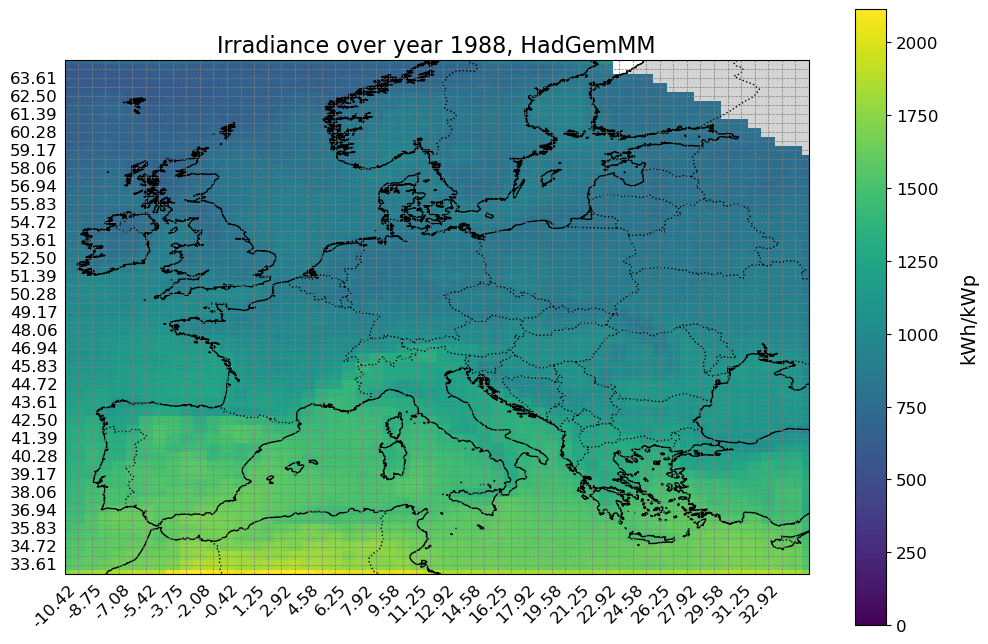

In [69]:
from plots import map_plots
map_plots(aggregated_generation_MM, cmap='viridis', vmin=0, vmax=None, title='Irradiance over year 1988, HadGemMM', label='kWh/kWp')

In [35]:
# Count the number of NaN values in ds['rsds']
nan_count = ds['tas'].isnull().sum().item()
print(f"Total number of NaN values in ds['rsds']: {nan_count}")

Total number of NaN values in ds['rsds']: 0


In [36]:
ds

<xarray.Dataset> Size: 30MB
Dimensions:   (time: 2928, lat: 26, lon: 25)
Coordinates:
  * time      (time) datetime64[ns] 23kB 1988-01-01T01:30:00 ... 1988-12-31T2...
  * lat       (lat) float32 104B 33.12 34.38 35.62 36.88 ... 61.88 63.12 64.38
  * lon       (lon) float32 100B -10.31 -8.438 -6.562 ... 30.94 32.81 34.69
Data variables:
    rsds      (time, lat, lon) float32 8MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rsdsdiff  (time, lat, lon) float32 8MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tas       (time, lat, lon) float64 15MB 201.2 198.5 195.9 ... 236.4 168.6

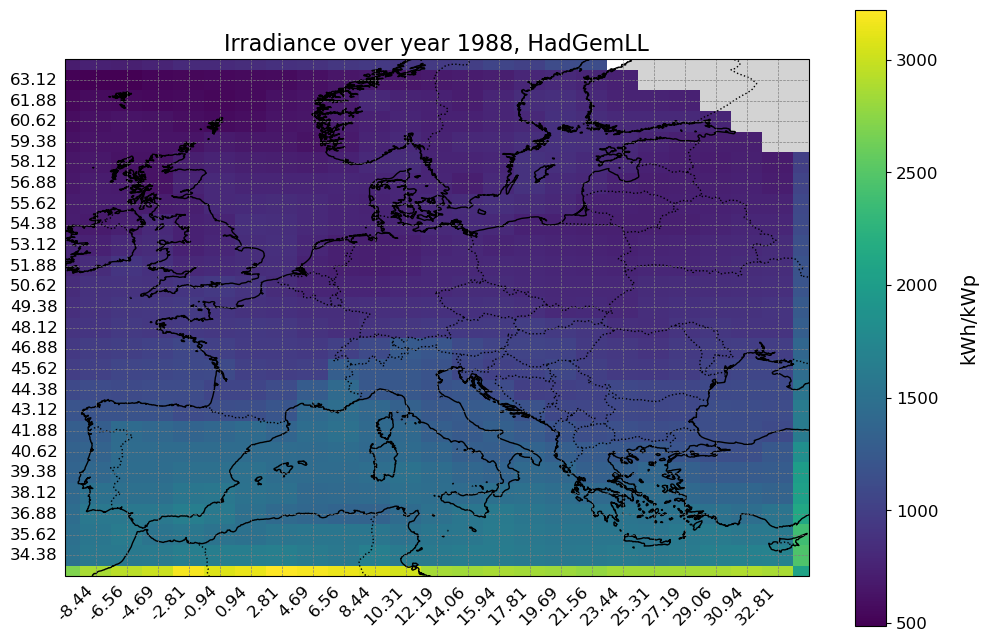

In [ ]:
map_plots(aggregated_generation_original, cmap='viridis', vmin=None, vmax=None, title='Irradiance over year 1988, HadGemLL', label='kWh/kWp')

In [ ]:
ds

<xarray.Dataset> Size: 30MB
Dimensions:   (time: 2880, lat: 26, lon: 25)
Coordinates:
  * time      (time) datetime64[ns] 23kB 1988-01-01T01:30:00 ... 1988-12-25T2...
  * lat       (lat) float32 104B 33.12 34.38 35.62 36.88 ... 61.88 63.12 64.38
  * lon       (lon) float32 100B -10.31 -8.438 -6.562 ... 30.94 32.81 34.69
Data variables:
    rsds      (time, lat, lon) float32 7MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rsdsdiff  (time, lat, lon) float32 7MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tas       (time, lat, lon) float64 15MB 69.37 69.18 68.34 ... 177.7 49.98

In [ ]:
# Print all the times(tamps in ds['time']
print(ds['time'].sel(time='1988-12').values)


['1988-12-01T01:30:00.000000000' '1988-12-01T04:30:00.000000000'
 '1988-12-01T07:30:00.000000000' '1988-12-01T10:30:00.000000000'
 '1988-12-01T13:30:00.000000000' '1988-12-01T16:30:00.000000000'
 '1988-12-01T19:30:00.000000000' '1988-12-01T22:30:00.000000000'
 '1988-12-02T01:30:00.000000000' '1988-12-02T04:30:00.000000000'
 '1988-12-02T07:30:00.000000000' '1988-12-02T10:30:00.000000000'
 '1988-12-02T13:30:00.000000000' '1988-12-02T16:30:00.000000000'
 '1988-12-02T19:30:00.000000000' '1988-12-02T22:30:00.000000000'
 '1988-12-03T01:30:00.000000000' '1988-12-03T04:30:00.000000000'
 '1988-12-03T07:30:00.000000000' '1988-12-03T10:30:00.000000000'
 '1988-12-03T13:30:00.000000000' '1988-12-03T16:30:00.000000000'
 '1988-12-03T19:30:00.000000000' '1988-12-03T22:30:00.000000000'
 '1988-12-04T01:30:00.000000000' '1988-12-04T04:30:00.000000000'
 '1988-12-04T07:30:00.000000000' '1988-12-04T10:30:00.000000000'
 '1988-12-04T13:30:00.000000000' '1988-12-04T16:30:00.000000000'
 '1988-12-04T19:30:00.000

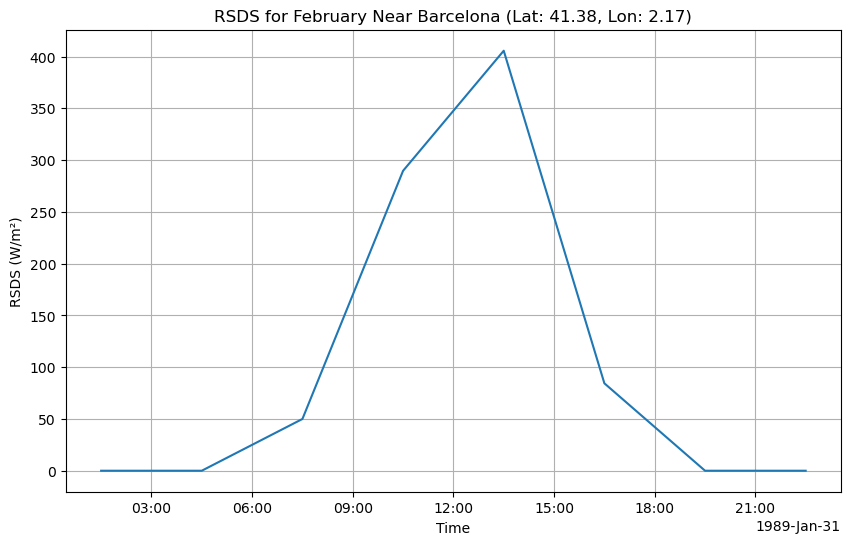

In [54]:
import matplotlib.pyplot as plt

# Define the latitude and longitude for Barcelona
latitude = 41.38
longitude = 2.17

# Select the data for February
ds_february = ds.sel(time='1989-01-31')

# Select the location near Barcelona
rsds_barcelona = ds_february['rsds'].sel(lat=latitude, lon=longitude, method='nearest')

# Plot the data
plt.figure(figsize=(10, 6))
rsds_barcelona.plot()
plt.title(f"RSDS for February Near Barcelona (Lat: {latitude}, Lon: {longitude})")
plt.xlabel("Time")
plt.ylabel("RSDS (W/m²)")
plt.grid()
plt.show()